# 📜 문서 타입 분류 대회

> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.30.화 10:00 ~ 2024.08.11.일 19:00

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
from glob import glob 
from PIL import Image
import albumentations as A
from albumentations import ImageOnlyTransform
from augraphy import *
from tqdm import tqdm
import shutil
import cv2
import platform

os_name = platform.system()
if os_name == 'Windows':
    PRE_PATH = ''
elif os_name == 'Linux':
    PRE_PATH = '/kkh/'
elif os_name == 'Darwin': # 맥
    PRE_PATH = '/kkh/'

TRAIN_KR_IMAGE_PATH = PRE_PATH + 'data/train_kr'
TRAIN_KR_AUG_IMAGE_PATH = PRE_PATH + 'data/train_kr_aug' # 증강한 이미지들을 담을 폴더명 미리 지정
META_KR_CSV_PATH = PRE_PATH + 'data/meta_kr.csv'
META_KR_DF = pd.read_csv(META_KR_CSV_PATH)
TRAIN_KR_CSV_PATH = PRE_PATH + 'data/train_kr.csv'
TRAIN_KR_DF = pd.read_csv(TRAIN_KR_CSV_PATH)

COUNT_PATCH = 1
ROTATE_ANGLE = 30

## 증강한 이미지들을 담을 폴더를 생성

In [18]:
# train_kr_aug_image_path 폴더 생성
def create_directory_with_backup(path):
    try:
        if os.path.exists(path):
            backup_path = path + '_backup'
            os.rename(path, backup_path)
            print(f"Existing folder renamed to: {backup_path}")
        os.makedirs(path)
        print(f"Folder created: {path}")
    except Exception as e:
        print(f"An error occurred: {e}")
create_directory_with_backup(TRAIN_KR_AUG_IMAGE_PATH)

Folder created: /kkh/data/train_kr_aug


In [19]:
class ImageDataset:
    def __init__(self, csv, directory, target_size=(380, 380)):
        self.df = pd.read_csv(csv).values
        self.directory = directory
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img_path = os.path.join(self.directory, name)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {name} not found in the directory {self.directory}")
        
        img = Image.open(img_path).resize(self.target_size)
        img = np.array(img)
        return img, target, name

## patching 적용

In [20]:
class PatchAugmentation:
    def __init__(self, max_patch_size=(32, 32)):
        self.max_patch_size = max_patch_size

    def __call__(self, img1, label1, img2, label2):
        h, w, _ = img1.shape
        ph, pw = min(self.max_patch_size[0], h), min(self.max_patch_size[1], w)
        x, y = np.random.randint(0, w - pw + 1), np.random.randint(0, h - ph + 1)
        img1[y:y + ph, x:x + pw] = img2[y:y + ph, x:x + pw]
        combined_label = label1  # Keep the label of the base image
        return img1, combined_label

# Load dataset
dataset = ImageDataset(TRAIN_KR_CSV_PATH, TRAIN_KR_IMAGE_PATH)
patch_augmenter = PatchAugmentation(max_patch_size=(32, 32))

patch_csv_data = []
for i in tqdm(range(len(dataset))):
    img, label, name = dataset[i]
    patch_csv_data.append([name, label])
    
    # Save original image to augmented directory
    original_img_path = os.path.join(TRAIN_KR_IMAGE_PATH, name)
    new_img_path = os.path.join(TRAIN_KR_AUG_IMAGE_PATH, name)
    shutil.copy(original_img_path, new_img_path)

# Augmentation loop
for i in tqdm(range(len(dataset))):
    img1, label1, name1 = dataset[i]
    
    # Select a random image2
    idx2 = np.random.randint(0, len(dataset))
    img2, label2, name2 = dataset[idx2]
    img_1_2, label_1_2 = patch_augmenter(img1, label1, img2, label2)

    # Select a random image3
    if COUNT_PATCH >= 2:
        idx3 = np.random.randint(0, len(dataset))
        img3, label3, name3 = dataset[idx3]
        img_1_2, label_1_2 = patch_augmenter(img_1_2, label_1_2, img3, label3)
    
    # Save augmented image
    new_name = f"patch_{name1}"
    augmented_img_pil = Image.fromarray(img_1_2.astype(np.uint8))
    augmented_img_pil.save(os.path.join(TRAIN_KR_AUG_IMAGE_PATH, new_name))
    
    # Append to new CSV data
    patch_csv_data.append([new_name, label_1_2])

patch_csv_df = pd.DataFrame(patch_csv_data, columns=['ID', 'target'])


  0%|          | 0/1570 [00:00<?, ?it/s]

100%|██████████| 1570/1570 [00:13<00:00, 112.30it/s]


## patching 내용을 train_kr_aug.csv 파일에도 추가한다.

In [21]:
TRAIN_KR_AUG_DF = pd.concat([patch_csv_df])
TRAIN_KR_AUG_CSV_PATH = PRE_PATH + 'data/train_kr_aug.csv'

if os.path.exists(TRAIN_KR_AUG_CSV_PATH):
    backup_path = TRAIN_KR_AUG_CSV_PATH.replace('.csv', '_backup.csv')
    os.rename(TRAIN_KR_AUG_CSV_PATH, backup_path)
TRAIN_KR_AUG_DF.to_csv(TRAIN_KR_AUG_CSV_PATH, index=False)

## albumentations 세팅

In [22]:
def to_tuple(param, low=None):
    if isinstance(param, (list, tuple)):
        return tuple(param)
    return (low, param) if low is not None else (param, param)

class SafeRotate(A.DualTransform):
    def __init__(self, limit, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], always_apply=False, p=1):
        super(SafeRotate, self).__init__(always_apply, p)
        self.limit = to_tuple(limit)
        self.interpolation = interpolation
        self.border_mode = border_mode
        self.value = value

    def apply(self, img, angle=0, **params):
        h, w = img.shape[:2]
        # Calculate the center and rotation matrix
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Calculate the sine and cosine (absolute values)
        abs_cos = abs(matrix[0, 0])
        abs_sin = abs(matrix[0, 1])

        # Find the new width and height bounds
        bound_w = int(h * abs_sin + w * abs_cos)
        bound_h = int(h * abs_cos + w * abs_sin)

        # Adjust the rotation matrix to consider the translation
        matrix[0, 2] += bound_w / 2 - center[0]
        matrix[1, 2] += bound_h / 2 - center[1]

        # Perform the actual rotation and return the image
        return cv2.warpAffine(img, matrix, (bound_w, bound_h), flags=self.interpolation, borderMode=self.border_mode, borderValue=self.value)

    def get_params(self):
        return {'angle': np.random.uniform(self.limit[0], self.limit[1])}

    def get_transform_init_args_names(self):
        return ('limit', 'interpolation', 'border_mode', 'value')

class CenterCropWithAspectRatio(A.DualTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(CenterCropWithAspectRatio, self).__init__(always_apply, p)

    def apply(self, img, **params):
        h, w = img.shape[:2]
        crop_size = int(0.7 * max(h, w))
        top = (h - crop_size) // 2
        left = (w - crop_size) // 2

        # Ensure crop coordinates are within bounds
        top = max(top, 0)
        left = max(left, 0)
        bottom = min(top + crop_size, h)
        right = min(left + crop_size, w)

        cropped_img = img[top:bottom, left:right]
        
        # Ensure the result is a numpy array
        return np.array(cropped_img)

    def get_transform_init_args_names(self):
        return []


In [23]:
base_aug_types = []

#####################################################################################

# 회전만 적용
def create_rotations():
    rotations = {}
    for angle in range(0, 360, ROTATE_ANGLE):
        key = f"r{angle:03d}_"
        rotations[key] = A.Compose([
            SafeRotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], p=1),
            CenterCropWithAspectRatio(),
            # A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], p=1),
        ])
    return rotations

base_aug_types.extend(create_rotations().items())

#####################################################################################

# 회전 + 가우시안 노이즈
def create_rotations_transforms(noise_value_min, noise_value_max):
    transforms = {}
    for angle in range(0, 360, ROTATE_ANGLE):
        key = f"hf_r{angle:03d}_n{noise_value_min}~{noise_value_max}_"
        transforms[key] = A.Compose([
            A.HorizontalFlip(p=1),
            SafeRotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], p=1),
            CenterCropWithAspectRatio(),
            # A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], p=1),
            A.GaussNoise(var_limit=(noise_value_min, noise_value_max), mean=0, p=1)
        ])
    return transforms

# 가우시안 노이즈 범위
noise_value_sets = [
    (500, 500),
    (1000, 1000)
]

for noise_value_min, noise_value_max in noise_value_sets:
    base_aug_types.extend(create_rotations_transforms(noise_value_min, noise_value_max).items())

#####################################################################################

## albumentations 이용해서, 이미지 증강 진행

Image augmentation:   3%|▎         | 100/3140 [00:44<21:34,  2.35it/s]

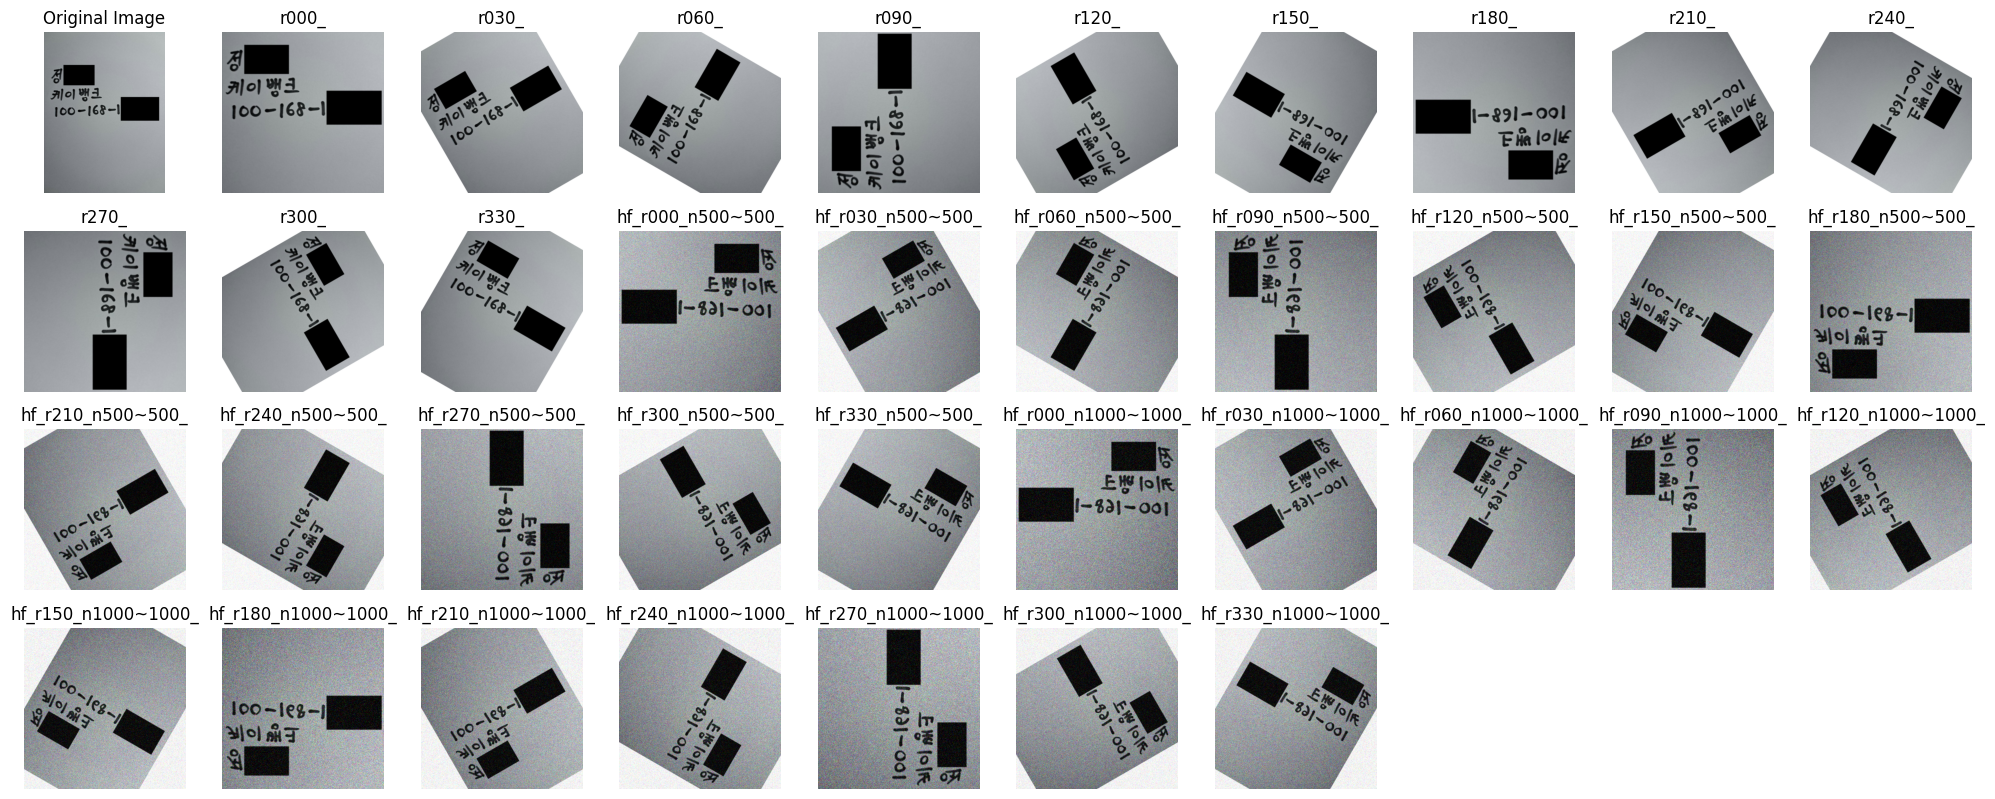

Image augmentation: 100%|██████████| 3140/3140 [17:20<00:00,  3.02it/s]


In [24]:
# 빈 리스트를 초기화합니다. 변환된 이미지의 ID와 타겟 정보를 저장할 것입니다.
ids = []
targets = []
 
# `train_kr_df` DataFrame의 각 행에 대해 반복합니다.
# `itertuples()`는 DataFrame을 튜플 형태로 반복할 수 있게 해줍니다.
for index, ID, target in tqdm(TRAIN_KR_AUG_DF.itertuples(), total=TRAIN_KR_AUG_DF.shape[0], desc='Image augmentation'):
    image_path = os.path.join(TRAIN_KR_AUG_IMAGE_PATH, ID)
    image = np.array(Image.open(image_path))
    
    # `base_aug_types`에 정의된 각 변환에 대해 반복합니다.
    for prefix, aug_function in base_aug_types:
        # 변환 함수를 사용하여 이미지를 변환합니다.
        transformed_image = aug_function(image=image)['image']
        new_ID = prefix + ID
        ids.append(new_ID)
        targets.append(target)
        Image.fromarray(transformed_image).save(os.path.join(TRAIN_KR_AUG_IMAGE_PATH, new_ID))

    # 인덱스가 100 인 경우, 원본 이미지와 변환된 이미지들을 시각적으로 표시합니다.
    if index == 100:
        # 원본 이미지 표시
        plt.figure(figsize=(20, 20))
        plt.subplot(10, 10, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')
        
        # 변환된 이미지들 표시
        for i, (prefix, aug_function) in enumerate(base_aug_types):
            # 변환 함수를 사용하여 이미지를 변환합니다.
            transformed_image = aug_function(image=image)['image']
            
            plt.subplot(10, 10, i + 2)
            plt.title(prefix)
            plt.imshow(transformed_image)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# 변환된 이미지의 ID와 타겟 정보를 담은 DataFrame을 생성합니다.
aug_data = {'ID': ids, 'target': targets}
aug_data_df = pd.DataFrame(aug_data)

## 엑셀 파일에 증강한 내용도 넣는다.

In [25]:
updated_df = pd.concat([TRAIN_KR_AUG_DF, aug_data_df], ignore_index=True)
updated_df.to_csv(TRAIN_KR_AUG_CSV_PATH, index=False)

## 원본과 증강까지한 내용들의 개수를 비교한다.

- /kkh/data/train_kr          원본 이미지 폴더
- /kkh/data/train_kr.csv      원본 엑셀 파일
- /kkh/data/train_kr_aug      증강 + 원본 이미지 폴더
- /kkh/data/train_kr_aug.csv  증강 + 원본 엑셀 파일

In [26]:
# 폴더 내 이미지 개수 확인(ls -1 . | wc -l)

# 원본만
image_count = len([f for f in os.listdir(TRAIN_KR_IMAGE_PATH) if os.path.isfile(os.path.join(TRAIN_KR_IMAGE_PATH, f))])
print(f"{TRAIN_KR_IMAGE_PATH} contains {image_count} images.")
# CSV 파일 내 이미지 개수 확인
df = pd.read_csv(TRAIN_KR_CSV_PATH)
csv_image_count = df.shape[0]
print(f"{TRAIN_KR_CSV_PATH} contains {csv_image_count} image records.")

print(f"=================================")

# 증강 + 원본
image_count = len([f for f in os.listdir(TRAIN_KR_AUG_IMAGE_PATH) if os.path.isfile(os.path.join(TRAIN_KR_AUG_IMAGE_PATH, f))])
print(f"{TRAIN_KR_AUG_IMAGE_PATH} contains {image_count} images.")
# CSV 파일 내 이미지 개수 확인
df = pd.read_csv(TRAIN_KR_AUG_CSV_PATH)
csv_image_count = df.shape[0]
print(f"{TRAIN_KR_AUG_CSV_PATH} contains {csv_image_count} image records.")

/kkh/data/train_kr contains 1570 images.
/kkh/data/train_kr.csv contains 1570 image records.
/kkh/data/train_kr_aug contains 116180 images.
/kkh/data/train_kr_aug.csv contains 116180 image records.


## 이상치 데이터들 정제한다.

In [27]:
# CSV 파일을 읽어옵니다.
df = pd.read_csv(TRAIN_KR_AUG_CSV_PATH)

# 45f0d2dfc7e47c03_입퇴원 확인서 --> 통원진료 확인서 --> 7
# aec62dced7af97cd_입퇴원 확인서 --> 소견서 --> 14
# 8646f2c3280a4f49_통원진료 확인서 --> 입퇴원 확인서 --> 3
# 1ec14a14bbe633db_소견서 --> 통원진료 확인서 --> 7
# 7100c5c67aecadc5_입퇴원 확인서 --> 통원진료 확인서 --> 7
# c5182ab809478f12_진단서 --> 소견서 --> 14
# 38d1796b6ad99ddd_약제비 영수증 --> 진료비 납입 확인서 --> 10
# 0583254a73b48ece_약제비 영수증 --> 진료비 납입 확인서 --> 10

# 조건에 따라 타겟 값을 변경하는 함수입니다.
def update_target(row):
    if "45f0d2dfc7e47c03" in row['ID']: return 7
    elif "aec62dced7af97cd" in row['ID']: return 14
    elif "8646f2c3280a4f49" in row['ID']: return 3
    elif "1ec14a14bbe633db" in row['ID']: return 7
    elif "7100c5c67aecadc5" in row['ID']: return 7
    elif "c5182ab809478f12" in row['ID']: return 14
    elif "38d1796b6ad99ddd" in row['ID']: return 10
    elif "0583254a73b48ece" in row['ID']: return 10
    else: return row['target']

df['target'] = df.apply(update_target, axis=1)
df.to_csv(TRAIN_KR_AUG_CSV_PATH, index=False)